In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np

columns =["system_name", "run_id", "latency", "operation", "on_leader", "n_nodes", "n_clients", "order_on_write"]
sns.set_theme()
sns.set(font_scale = 1.2)

# Reading Data

In [2]:
data_exp_2_df = pd.DataFrame(columns=columns)

for f in glob.glob("results/experiment1_*"):
    temp_df = pd.read_csv(f)
    data_exp_2_df = data_exp_2_df.append(temp_df, ignore_index=True)

In [3]:
columns =["system_name", "run_id", "latency", "operation", "on_leader", "n_nodes", "n_clients", "order_on_write"]
data_exp_1_df = pd.DataFrame(columns=columns)

for f in glob.glob("results/experiment3_*"):
    with open(f, "r") as f:
        raw_data = f.readlines()[1]
        lines = raw_data.replace("\",\"", "\n").replace("[","").replace("]", "").replace(" ", "").replace("'", "")[1:-2].split("\n")
        lines = [line.split(",") for line in lines]

        lines = [line for line in lines if line[2] != "None"]

        temp_df = pd.DataFrame(lines, columns=columns)
        temp_df['latency'] = temp_df['latency'].astype(np.float64)
        temp_df['n_nodes'] = temp_df['n_nodes'].astype(int)
        temp_df['n_clients'] = temp_df['n_clients'].astype(int)
        temp_df['on_leader'] = temp_df['on_leader'] == "True"
        temp_df['order_on_write'] = temp_df['order_on_write'] == "True"
        data_exp_1_df = data_exp_1_df.append(temp_df, ignore_index=True)

# Transforming Data

In [4]:
data_df = pd.concat([data_exp_1_df, data_exp_2_df[(data_exp_2_df["n_clients"] != 1) & (data_exp_2_df["latency"] < 3)]])
data_df = data_df[data_df["n_clients"] != 100]
data_df["latency"] = data_df["latency"]  * 1000

data_df["Node"] = "None"
data_df["Node"] = data_df["on_leader"].apply(lambda x: "Leader" if x else "Follower")
data_df = data_df.rename(columns={"n_nodes": "Nodes", "operation": "Operation", "n_clients": "Clients"})
data_df["Type"] = data_df["order_on_write"].apply(lambda x: "Benchmark" if x else "MangoDB")

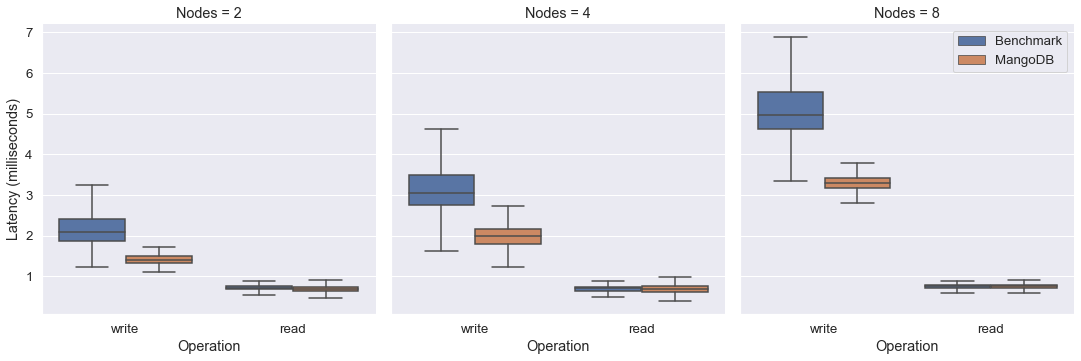

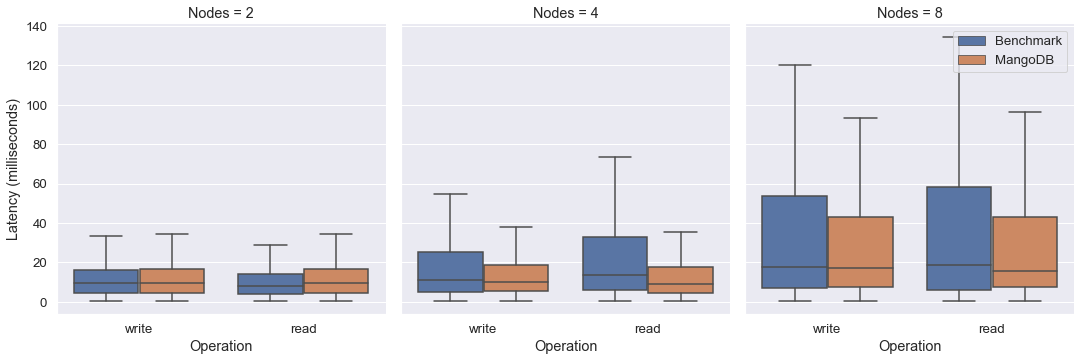

In [5]:
for group_name, group_df in data_df.groupby(["Clients"]):
    ax = sns.catplot(kind="box", x="Operation", y="latency", hue="Type", hue_order=["Benchmark", "MangoDB"], col="Nodes", data=group_df, showfliers=False, legend=False)
    ax.set_ylabels("Latency (milliseconds)")
    plt.legend(loc='upper right')
    plt.savefig("results/exp_3_{}.png".format(group_name), bbox_inches='tight', dpi=300)

In [6]:
for group_name, group_df in data_df.groupby(["Nodes", "Type", "Operation"]):
    increase = group_df[group_df["Clients"] == 1000]["latency"].median() / group_df[group_df["Clients"] == 1]["latency"].median()
    print(group_name, group_df["latency"].median(), increase)

(2, 'Benchmark', 'read') 0.7223219145089388 11.265904732308043
(2, 'Benchmark', 'write') 2.084219828248024 4.486192770564575
(2, 'MangoDB', 'read') 0.6886681076139212 13.774793132027265
(2, 'MangoDB', 'write') 1.4116410166025162 6.737342025318836
(4, 'Benchmark', 'read') 0.6986632943153381 19.189770307869313
(4, 'Benchmark', 'write') 3.0379234813153744 3.6876491008407
(4, 'MangoDB', 'read') 0.6846690084785223 12.984063134551219
(4, 'MangoDB', 'write') 1.9951914437115192 5.036999426492142
(8, 'Benchmark', 'read') 0.7483977824449539 25.251012402090904
(8, 'Benchmark', 'write') 4.975079675205052 3.553146971732022
(8, 'MangoDB', 'read') 0.7495628669857979 21.11059260584777
(8, 'MangoDB', 'write') 3.285942832008004 5.190855810873745


No handles with labels found to put in legend.


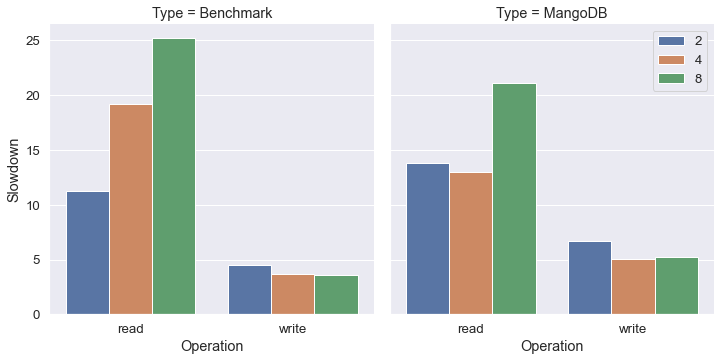

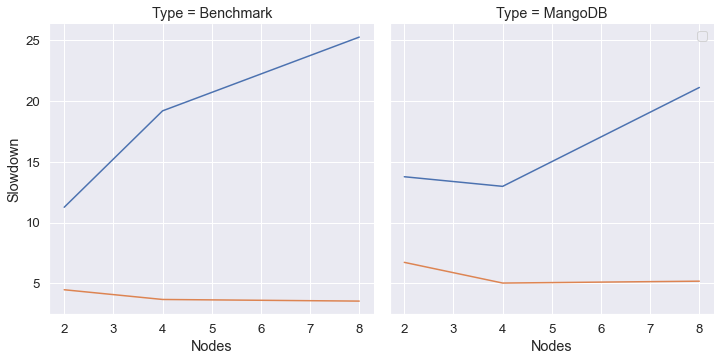

In [7]:


temp_df = data_df.groupby(["Nodes", "Type", "Operation"]).apply(lambda df: df[df["Clients"] == 1000]["latency"].median() / df[df["Clients"] == 1]["latency"].median()).reset_index()
temp_df = temp_df.rename(columns={0: "Slowdown"})

sns.catplot(kind="bar", x="Operation", y="Slowdown", hue="Nodes", col="Type", data=temp_df, legend=False)
plt.legend(loc='upper right')
plt.savefig("results/exp_3_slowdown.png", bbox_inches='tight', dpi=300)

sns.relplot(kind="line", x="Nodes", y="Slowdown", hue="Operation", col="Type", data=temp_df, legend=False)
plt.legend(loc='upper right')
plt.savefig("results/exp_3_slowdown_line.png", bbox_inches='tight', dpi=300)
